# Prótesis avanzadas
## Modelos de Inteligencia Artificial para control de prótesis con EMG

### Autor: Carlos José Muñoz Cabrera
### Asesor: Daniel Escobar

Este proyecto busca definir un modelo de inteligencia artificial que permita, a partir de la extracción de de caracteristicas de señales EMG, obtener una clasificación de movimientos específicos que puede realizar el usuario y que son los más comunes y usados por la empresa Protesis Avanzadas. Las bases de datos que se usarán para poder realizar este proyecto son las compartidas por NINAPRO, cuya descripción se encuentra en el siguiente documento: ArticuloExplicaciónDB1&DB2.pdf en la carpeta de drive compaertida por la empresa. 

Inicialmente se hace la extracción de datos contenidos en los registros para el primer paciente. Según la documentación y explicación de la base de datos, los registros tienen ciertas características a tener en cuenta y que se van a ir describiendo a lo largo del desarrollo del presente trabajo. 

In [1]:
#Import libraries
import src
from scipy.io import loadmat, whosmat
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt 
import os
import pandas as pd
from src import config

### Importante:

La linea a continuación se usa para descargar los datos de las bases de datos de ninapro. El proceso tarda bastante dado que depende del internet por lo que es mejor explorar la opción de realizarlo manualmente desde la pag de nina-pro

In [2]:
#src.prepare_download_data(3)


Se va a verificar los items que contiene el archivo matlab que contiene la información del primer sujeto S1_A1_E1. Estos datos se encuentran registrados en un archivo con extensión .mat. Hacemos uso de la librería scipy ya que es la que se usa parfa el tratamiento de este tipo de datos. 

In [3]:
database = 'DB1'


file = 'Ninapro/DB1/s1/S1_A1_E3.mat'
#Get the description of the information cantained in the file
info = whosmat(file) 
#Get the information contained in the file
mat_file = loadmat(file)
#Print every component in the description of the file
for item in info:
    print(item)  

('emg', (227493, 10), 'double')
('stimulus', (227493, 1), 'double')
('glove', (227493, 22), 'double')
('subject', (1, 1), 'double')
('exercise', (1, 1), 'double')
('repetition', (227493, 1), 'double')
('restimulus', (227493, 1), 'double')
('rerepetition', (227493, 1), 'double')


In [4]:
#Access each of the matrices by its name
emg = mat_file['emg']
stimulus = mat_file['stimulus']
glove = mat_file['glove']
subject = mat_file['subject']
exercise = mat_file['exercise']
repetition = mat_file['repetition']
restimulus = mat_file['restimulus']
rerepetition = mat_file['rerepetition']


A continuación se procede a explorar cada una de las matrices contenidas en el archivo, dando una breve descripción de la información que contienen. Con el objetivo de conocer con más detalle que es lo que cada archivo contiene.

No se tiene una base de tiempo. 

### 1. EMG
Los valores de emg incluyen la señal sEMG obtenida por los electrodos. La columna 1 a la 8 incluyen la señal obtenida de los electrodos igualmente espaciados en el antebrazo.
La columna 9 y 10 hace referencia a los electrodos ubicados en la principal zona de activación del músculo flexor superficial de los dedos y el musculo extensor superficial de los dedos. Si existe un electrodo 11 y 12, pertenece a la señal de activación del músculo biceps braquial y triceps braquial.


In [5]:
#Print emg Matrix
print("Valores de 'emg':")
print(f'Tipo de dato: {type(emg)}')
print(emg)

Valores de 'emg':
Tipo de dato: <class 'numpy.ndarray'>
[[0.0024 0.0024 0.0024 ... 0.0732 0.0024 0.0903]
 [0.0024 0.0024 0.0024 ... 0.0757 0.0024 0.0928]
 [0.0024 0.0024 0.0024 ... 0.0879 0.0024 0.0903]
 ...
 [0.0024 0.0024 0.0024 ... 0.0513 0.127  0.0024]
 [0.0024 0.0024 0.0024 ... 0.0488 0.1294 0.0024]
 [0.0024 0.0024 0.0024 ... 0.0439 0.1294 0.0024]]


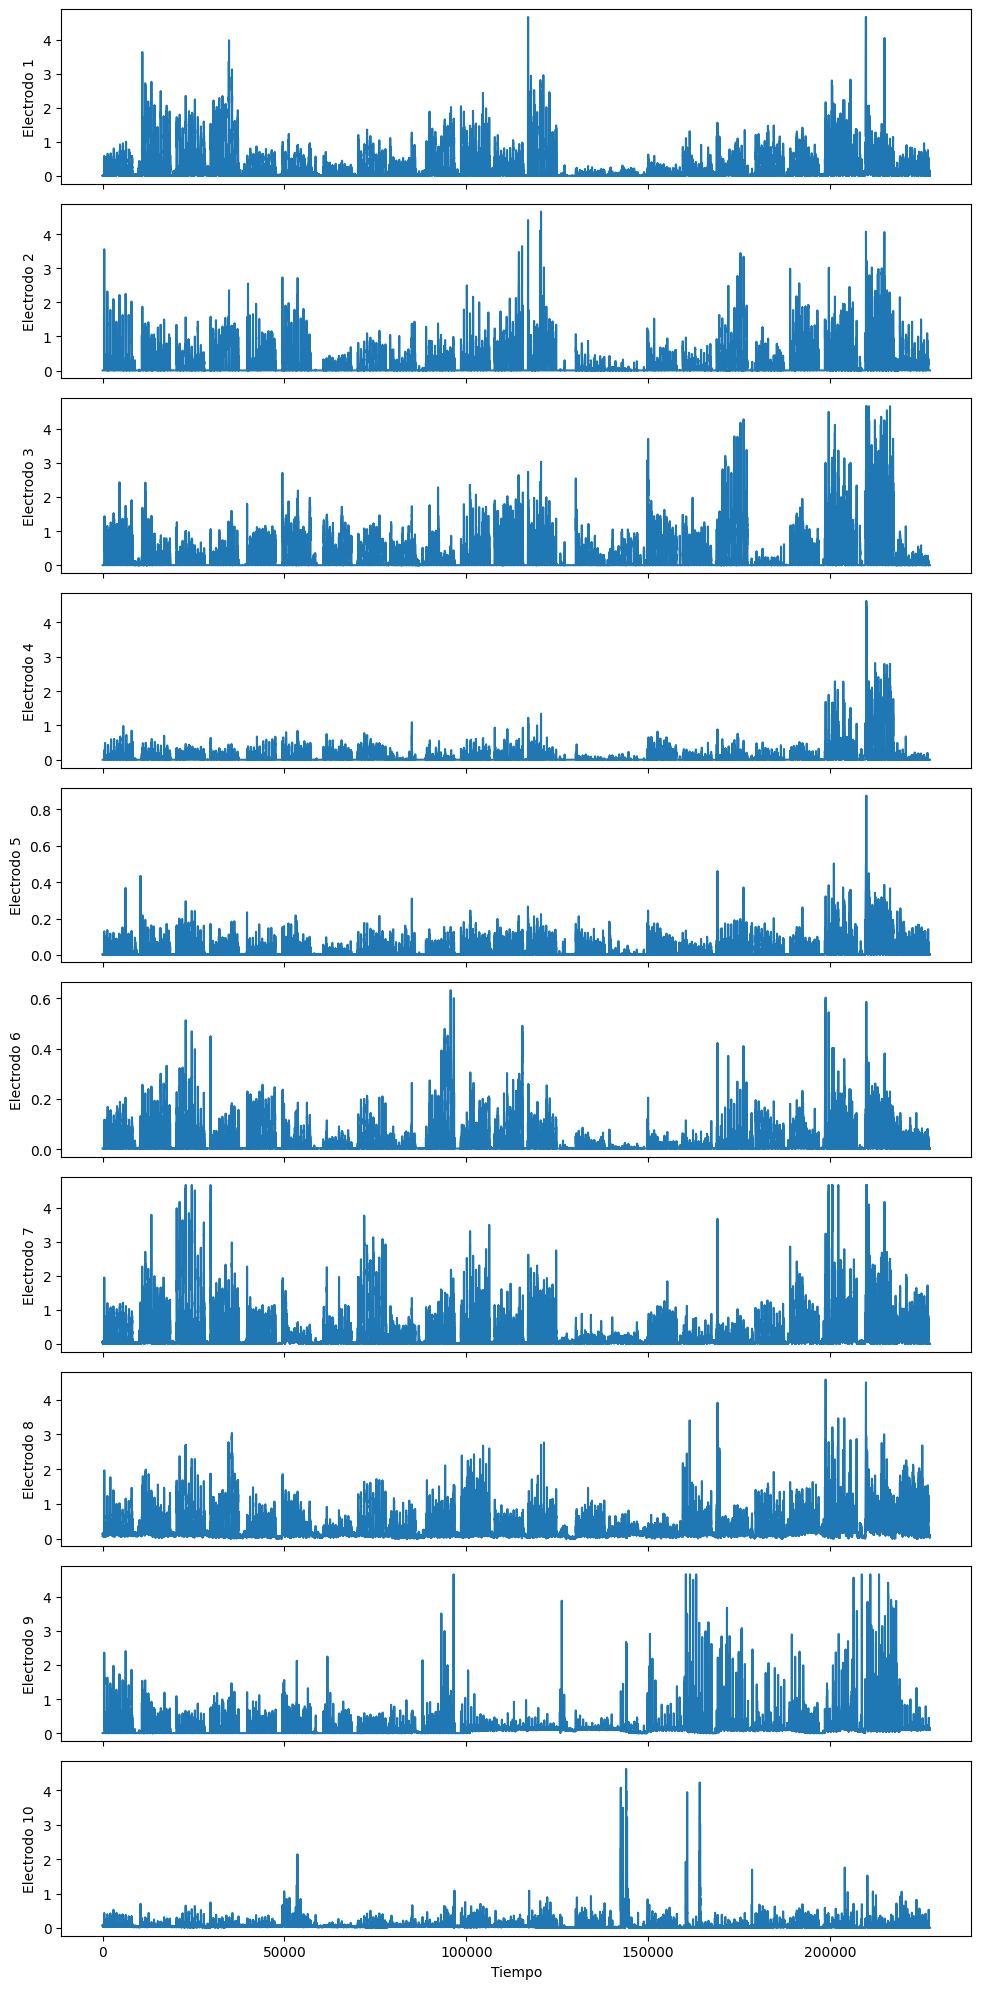

In [6]:
#Plot the emg signal
fig, axs = plt.subplots(10, 1, figsize=(10, 20), sharex=True)

for i, ax in enumerate(axs):
    ax.plot(emg[:, i])
    ax.set_ylabel(f'Electrodo {i+1}')
    ax.grid=True

axs[-1].set_xlabel('Tiempo')

plt.tight_layout()

# plt.show()

### 2. Stimulus
Representa la etiqueta original del movimiento que está realizando el sujeto. Estos movimientos deben clasificarse en los que se va a usar en protesis avanzadas y los que no, por esta razón es necesario hacer la clasificación de dichas etiquetas. 

In [7]:
print("Valores de 'stimulus':")
unique_values = np.unique(stimulus)

# Print unique values
print(unique_values)


Valores de 'stimulus':
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


Text(0.5, 1.0, 'Valor del estímulo')

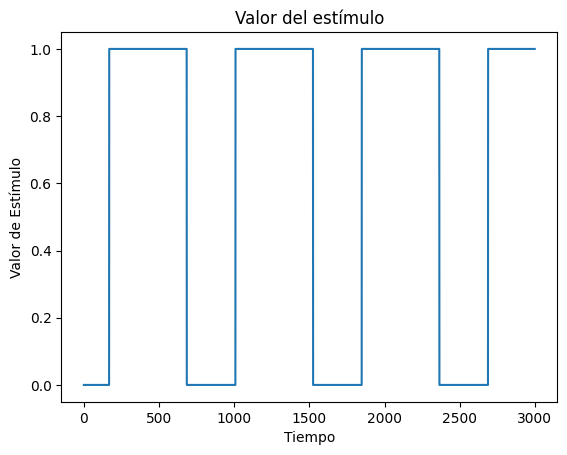

In [8]:
#Plot the stimulus
fig, ax = plt.subplots()

ax.plot(stimulus[1000:4000])

ax.set_xlabel('Tiempo')
ax.set_ylabel('Valor de Estímulo')
ax.set_title('Valor del estímulo')

# plt.show()

### 3. Glove
Los valores de glove hacen referencia a la señal no calibrada de los 22 sensores de cyberglove que son úbicados en las manos. 

In [9]:
print("Valores de 'glove':")
print(glove)

Valores de 'glove':
[[152. 137. 111. ... 139. 134. 108.]
 [152. 137. 111. ... 139. 134. 108.]
 [152. 137. 111. ... 139. 134. 108.]
 ...
 [152. 131. 114. ... 124. 133. 120.]
 [152. 131. 114. ... 124. 133. 120.]
 [152. 131. 114. ... 124. 133. 120.]]


### 4. Subject

El subject se refiere al sujeto en cuestión que está realizando la prueba y de quien pertencen los registros

In [10]:
print("Valor de 'subject':")
print(subject)

Valor de 'subject':
[[1]]


### 4. Excercise

Se refiere al numero del ejercicio que fue realizado por el sujeto. En esta base de datos se cuenta con 3 tipos de ejercicios que tienen diferentes movimientos según sea el caso

In [11]:
print("Valor de 'exercise':")
print(exercise)

Valor de 'exercise':
[[3]]


### 5. Repetition:
Se refiere al indice de repetición del estímulo

In [12]:
print("Valores de 'repetition':")
unique_values = np.unique(repetition)

# Print unique values
print(unique_values)

Valores de 'repetition':
[ 0  1  2  3  4  5  6  7  8  9 10]


Text(0.5, 1.0, 'Valor del Repetition')

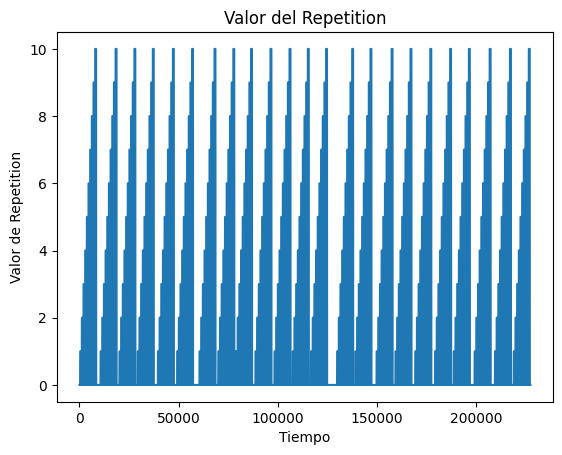

In [13]:
#Plot the repetition
fig, ax = plt.subplots()

ax.plot(repetition)

ax.set_xlabel('Tiempo')
ax.set_ylabel('Valor de Repetition')
ax.set_title('Valor del Repetition')

# plt.show()

### 6. Restimulus

Se refiere a la etiqueta refinada a-posteriori del movimiento realizado por el sujeto

In [14]:
print("\nValores de 'restimulus':")
unique_values = np.unique(restimulus)

# Print unique values
print(unique_values)


Valores de 'restimulus':
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]


Text(0.5, 1.0, 'Valor del restimulus')

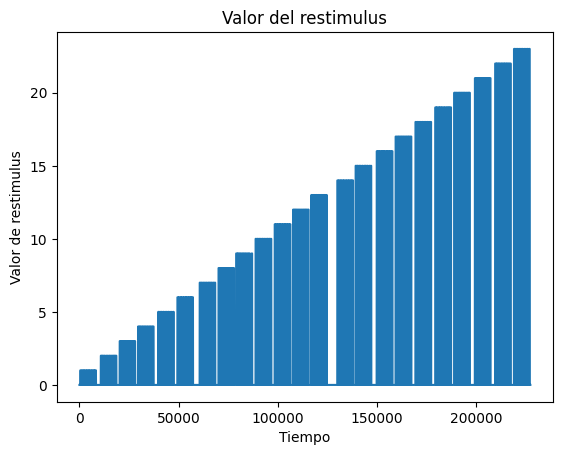

In [15]:
#Plot the restimulus
fig, ax = plt.subplots()

ax.plot(restimulus)

ax.set_xlabel('Tiempo')
ax.set_ylabel('Valor de restimulus')
ax.set_title('Valor del restimulus')

# plt.show()

### 7. Rerepetition

Se refiere al indice de repetición del estimulo

In [16]:
print("Valores de 'rerepetition':")
unique_values = np.unique(rerepetition)

# Print unique values
print(unique_values)

Valores de 'rerepetition':
[ 0  1  2  3  4  5  6  7  8  9 10]


Text(0.5, 1.0, 'Valor del Rerepetition')

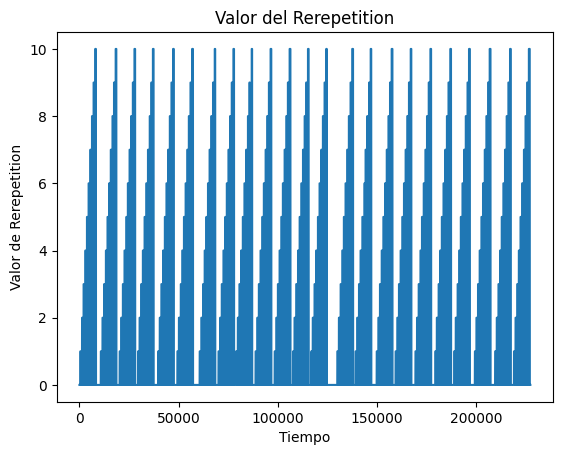

In [17]:
#Plot the Rerepetition
fig, ax = plt.subplots()

ax.plot(rerepetition)

ax.set_xlabel('Tiempo')
ax.set_ylabel('Valor de Rerepetition')
ax.set_title('Valor del Rerepetition')

# plt.show()

Como se puede ver en las gráficas. Para este primer ejercicio, por cada movimiento se realizaron 10 repeticiones y volviendo al estado de reposo que se indica en el articulo de explicación de la base de datos. Dado que no se van a usar todos los movimientos, solo los que se asocian con los que usa la empresa, es necesario hacer una división de las señales de emg y glove para poder definir cuales sonlas señales correspondientes al movimiento y su repetición. 

Dado que tenemos una señal de restimulus, vamos a usar esta como punto de partida para hacer dicha división, tomando la sincronía que debe tener la señal. Existen dos opciones que se deben discutir, la primera es que se pueden segmentar las señales de inicio de estímulo a inicio de estímulo o de fin de estímulo a fin de estímulo.

En este mommento se va a realizar la segmentación solo cuando el estímulo se encuentra activo. Sin embargo, es algo que se debe discutir con el asesor.

Entonces, para el proceso. Primero encontramos los indices donde se realiza el estímulo. La idea es encontras los indices donde el estímulo es diferente de 0.

In [18]:
start_index_stimulus, end_index_stimulus = src.get_stimulus_index(restimulus)
# print('start index stimulus: ', start_index_stimulus)
# print('start index stimulus len: ', len(start_index_stimulus))
# print('end index stimulus: ', end_index_stimulus)
# print('end index stimulus len : ', len(end_index_stimulus))


Los indices de inicio indican el momento antes de comenzar el estímulo, por lo que el inicio comienza en n+1

In [19]:
print(f'Start index: {restimulus[391][0]}')
print(f'Start real: {restimulus[717][0]}')
print(f'End real index: {restimulus[1259][0]}')

Start index: 1
Start real: 1
End real index: 0


Ahora se procede a segmentar la señal de los sensores EMG para poder así obtener la señal con su respectiva etiqueta. Según  lo conversado en las reuniones de segumiento, los movimientos que se van a tener en cuenta en el primer ejercicio son los 9,10,11,12. De esta manera se procede a segmentar estos indices de las señales de emg.

In [20]:
movements = np.array([5,6,9,10])

filtered_start_index_stimulus = src.get_start_end_index(start_index_stimulus, end_index_stimulus, movements, 10)

In [21]:
print(filtered_start_index_stimulus['5'])

{'start': array([39668, 40474, 41279, 42145, 43035, 43849, 44665, 45544, 46371,
       47180]), 'end': array([37397, 40067, 40847, 41691, 42537, 43365, 44223, 45074, 45870,
       46729, 47584])}


In [22]:
for i in filtered_start_index_stimulus:
    print(i)

5
6
9
10


Para este primer ejemplo, la señal está iniciando con el primer end index +1 ya que es aquí donde comienza el reposo y despúes se obtiene la señal dónde comienza el estimulo

In [23]:
print(f'Este es el inicio del reposo: {restimulus[37397+1][0]}')
print(f'Aquí es donde comienza el estímulo: {restimulus[39668+1][0]}')
print(f'Aquí es donde termina el estímulo: {restimulus[47584][0]}')

Este es el inicio del reposo: 0
Aquí es donde comienza el estímulo: 5
Aquí es donde termina el estímulo: 5


Como se observa anteriormente, hemos guardado en el diccionario 10 indices que indican el inicio del estímulo en cuestion y 11 que indican el fin del estímulo o el comienzo del reposo. Dado que tenemos la señal de emg sincronizada con la señal de restimulus, entonces usaremos el mismo indice para hacer la segmentación de dicha señal logrando que una señal empiece en el reposo y termine cuando se termina el estímulo. Sin embargo, es preciso determinar si es mejor segmentar la señal cuando se tiene solo estímulo o cuando se tiene solo reposo.

In [24]:
segmented_signals = src.get_signal_by_movement_complete(emg[:,0], filtered_start_index_stimulus['5'])

In [25]:
segmented_restimulus = src.get_signal_by_movement_complete(restimulus, filtered_start_index_stimulus['5'])

In [26]:
print(segmented_signals)

[0.1025 0.0757 0.0635 ... 0.0024 0.0024 0.0024]


Procedemos a Graficarlas para poder verificar visualmente

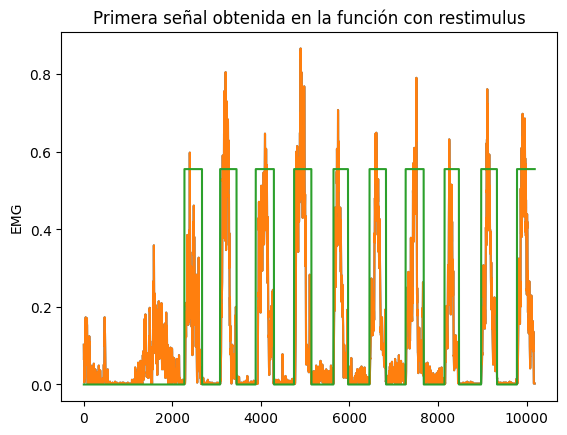

In [27]:
fig, ax = plt.subplots() # Eje X en escala de tiempo

ax.plot(segmented_signals)
ax.plot(emg[37397+1:47584, 0])
ax.plot(segmented_restimulus*1/9)

ax.set_ylabel('EMG')
ax.set_title('Primera señal obtenida en la función con restimulus')

plt.show()

Dado que ya tenemos las señales segmentadas, se procede a obtener la envolvente, primero sin aplicar filtros y después aplicando un filtro

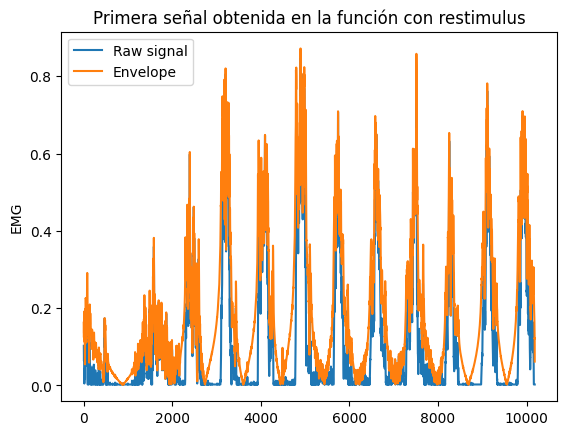

In [29]:
envelope = src.get_envelope(segmented_signals)

fig, ax = plt.subplots()

ax.plot(segmented_signals)
ax.plot(envelope)

ax.set_ylabel('EMG')
ax.set_title('Primera señal obtenida en la función con restimulus')
ax.legend(['Raw signal', 'Envelope'])

# plt.show()


In [30]:
filtered_signal = src.get_filtered_signal(segmented_signals, 10, 2000)

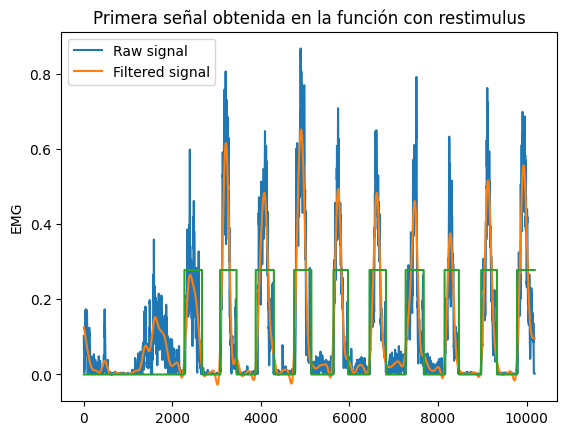

In [31]:
fig, ax = plt.subplots()

ax.plot(segmented_signals)
ax.plot(filtered_signal)
ax.plot(restimulus[37397+1:47584]/(2*9))

ax.set_ylabel('EMG')
ax.set_title('Primera señal obtenida en la función con restimulus')
ax.legend(['Raw signal', 'Filtered signal'])

plt.show()

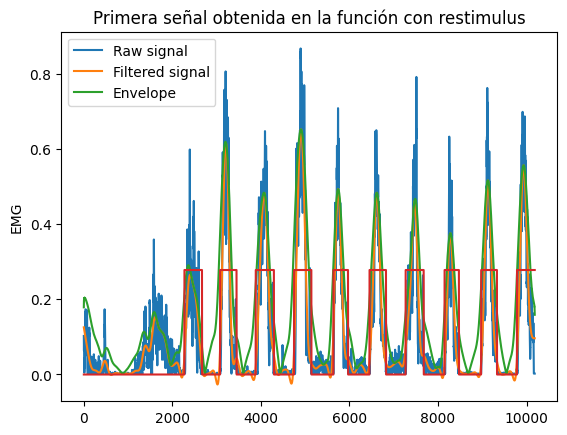

In [32]:
envelope = src.get_envelope(filtered_signal)

fig, ax = plt.subplots()

ax.plot(segmented_signals)
ax.plot(filtered_signal)
ax.plot(envelope)
ax.plot(restimulus[37397+1:47584]/(2*9))

ax.set_ylabel('EMG')
ax.set_title('Primera señal obtenida en la función con restimulus')
ax.legend(['Raw signal', 'Filtered signal', 'Envelope'])

plt.show()

In [33]:
main_folder_path = f'Ninapro/DB1/'
signal_paths = []
for folder in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder)  
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path) and 'E3' in file and file.endswith('.mat'):
                signal_paths.append(file_path)

print(signal_paths)

['Ninapro/DB1/s14/S14_A1_E3.mat', 'Ninapro/DB1/s26/S26_A1_E3.mat', 'Ninapro/DB1/s23/S23_A1_E3.mat', 'Ninapro/DB1/s4/S4_A1_E3.mat', 'Ninapro/DB1/s5/S5_A1_E3.mat', 'Ninapro/DB1/s3/S3_A1_E3.mat', 'Ninapro/DB1/s2/S2_A1_E3.mat', 'Ninapro/DB1/s9/S9_A1_E3.mat', 'Ninapro/DB1/s7/S7_A1_E3.mat', 'Ninapro/DB1/s10/S10_A1_E3.mat', 'Ninapro/DB1/s18/S18_A1_E3.mat', 'Ninapro/DB1/s17/S17_A1_E3.mat', 'Ninapro/DB1/s24/S24_A1_E3.mat', 'Ninapro/DB1/s19/S19_A1_E3.mat', 'Ninapro/DB1/s11/S11_A1_E3.mat', 'Ninapro/DB1/s22/S22_A1_E3.mat', 'Ninapro/DB1/s6/S6_A1_E3.mat', 'Ninapro/DB1/s12/S12_A1_E3.mat', 'Ninapro/DB1/s21/S21_A1_E3.mat', 'Ninapro/DB1/s1/S1_A1_E3.mat', 'Ninapro/DB1/s27/S27_A1_E3.mat', 'Ninapro/DB1/s16/S16_A1_E3.mat', 'Ninapro/DB1/s8/S8_A1_E3.mat', 'Ninapro/DB1/s20/S20_A1_E3.mat', 'Ninapro/DB1/s25/S25_A1_E3.mat', 'Ninapro/DB1/s13/S13_A1_E3.mat', 'Ninapro/DB1/s15/S15_A1_E3.mat']


Creamos una rutina para iterar sobre cada BD con el ejercicio 3 que son los que usaremos para la clasificación. Aunque, se va a explorar sobre los demás ejercicios, buscando obtener los movimientos que más se diferencian.

In [34]:
#All column titles are created with features to classify signals.
column_titles = ['label']
features = config.FEATURES
for i in range(8):
    for feature in features.keys():
        column_titles.append(feature+str(i+1))
signals_features = pd.DataFrame(columns=column_titles)
print(signals_features)

Empty DataFrame
Columns: [label, RMS_E1, MAV_E1, VARIANCE_E1, SAMPLE_VARIANCE_E1, RMS_E2, MAV_E2, VARIANCE_E2, SAMPLE_VARIANCE_E2, RMS_E3, MAV_E3, VARIANCE_E3, SAMPLE_VARIANCE_E3, RMS_E4, MAV_E4, VARIANCE_E4, SAMPLE_VARIANCE_E4, RMS_E5, MAV_E5, VARIANCE_E5, SAMPLE_VARIANCE_E5, RMS_E6, MAV_E6, VARIANCE_E6, SAMPLE_VARIANCE_E6, RMS_E7, MAV_E7, VARIANCE_E7, SAMPLE_VARIANCE_E7, RMS_E8, MAV_E8, VARIANCE_E8, SAMPLE_VARIANCE_E8]
Index: []

[0 rows x 33 columns]


In [35]:
movements_label = config.MOVEMENTS_LABEL
movements_as_integers = sorted(list(map(int, movements_label.keys())))

The selected movements for our database construction are [0, 5, 6, 9, 10, 13, 17] of S3 of DB1.

The excercise numbering is different in DB1 and the following DBs, as movement number is not reset between excercises.  And the exercises contained vary:
https://www.nature.com/articles/sdata201453/tables/2

That means that number 5 in DB1-E3 corresponds to number 22 in the following DBs.
(https://ninapro.hevs.ch/figures/SData_Movements.png)

In [ ]:
#Routine to create data frame with characteristics and labels.
databases = config.DATABASES
fc= config.FC #Cutoff frequency in Hz
windowing = config.WINDOWING #s time of the window // Ej: 0.2s = 200 ms
overlapping = config.OVERLAPPING #% overlapping percentage
repetitions = config.REPETITIONS #Number of times a movement is repeated
electrodes = config.ELECTRODES #Number of electrodes used in the experiment
threshold = config.THRESHOLD # Characterization percentage
for database, fm in databases.items(): #Iterates over databases
    window_length = int(windowing * fm)
    subjects = src.get_file_path_database(database)
    for individual in subjects: #Iterates over individuals in the experiments
        mat_file = loadmat(individual)
        emg = mat_file['emg']
        re_stimulus = mat_file['restimulus']
        re_repetition = mat_file['rerepetition']
        start_index_re_stimulus, end_index_re_stimulus = src.get_stimulus_index(re_stimulus) # Get the start and end index of the entire set of repetitions for an exercise.
        filtered_start_index_re_stimulus = src.get_start_end_index(
            start_index_re_stimulus, 
            end_index_re_stimulus, 
            movements_as_integers, 
            repetitions
        ) #Get the segments of the entire set of repetitions for an exercise. 
        for movement in movements_as_integers: #Iterates over the movements implied in the classification 
            if movement == 0:
                continue
            segmented_re_stimulus = src.get_signal_by_movement_complete(re_stimulus, filtered_start_index_re_stimulus[str(movement)]) #Gets the signal of the movement
            windows_re_stimulus = src.create_windows_with_overlap(segmented_re_stimulus, window_length, overlapping)
            labels = []
            for window in windows_re_stimulus:
                label = src.get_label(window, threshold, movements_label, database)
                labels.append(label)
            emg_signals = []
            for electrode in range(electrodes):
                segmented_emg_signal = src.get_signal_by_movement_complete(emg[:, electrode], filtered_start_index_re_stimulus[str(movement)])
                filtered_segmented_emg_signal = src.get_envelope_filtered(segmented_emg_signal, fc, fm)
                windows_emg_electrode = src.create_windows_with_overlap(filtered_segmented_emg_signal, window_length, overlapping)
                emg_signals.append(windows_emg_electrode)
            windows_quantity  = len(emg_signals[0])
            if (windows_quantity != len(labels)):
                print('Different longitude in labels with electrodes', movement, individual, database) #This is used to check the windows between labels and windows in electrodes
                raise ValueError('No es compatible')
            for index_label,label in enumerate(labels):
                if not label:
                    print(label)
                data_label = {
                    'label': label,
                }
                for index_electrode, element in enumerate(emg_signals):
                    if len(element) != windows_quantity:
                        print('Different longitude in electrodes', index_electrode, movement, individual, database) #This is used to find any signal with different number of window
                        raise ValueError('No es compatible')
                    for feature, function in features.items():
                        feature_calculus = function(element[index_label])
                        data_label[feature+str(index_electrode+1)] = np.array([feature_calculus])
                new_data_label = pd.DataFrame(data_label)
                signals_features = pd.concat([signals_features, new_data_label], ignore_index=True)


In [ ]:
signals_features.info()

In [ ]:
signals_features.describe()

In [ ]:
signals_features['label'].value_counts()

In [39]:
#Save dataframe 
signals_features.to_pickle('preprocessed_data/signals_50OL_03Windowing.pkl')

# Análisis y limpieza de datos

Una vez se logra obtener el dataset completo se procede a hacer un análisis y limpieza de datos para poder ingresarlos a los diferentes algoritmos de clasificación


In [42]:
import pandas as pd
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [ ]:
signals_features_df = pd.read_pickle('preprocessed_data/signals_50OL_03Windowing.pkl') #upload data_frame
print('Head of dataset:')
print(signals_features_df.head())

In [ ]:
print('Numeric data information:')
print(signals_features_df.info())

In [ ]:
print('Numeric data description:')
print(signals_features_df.describe())

In [ ]:
signals_features_df['label'].value_counts()

In [48]:
index_to_delete = signals_features_df[signals_features_df['label'] == 'None'].index

signals_features_df.drop(index_to_delete, inplace=True)

Es importante recalcar que las etiquetas clasificadas como Base superan en gran medida a las demás etiquetas a clasificar por lo que vamos a aplicar submuetreo sobre los datos para poder igualar los datos de la base y que sea de manera aleatoria. De esta manera buscamos balancear los datos y que así no exista un  sesgo en la clasificación.


In [ ]:
X = signals_features_df.drop('label', axis=1)
y = signals_features_df['label']

rus = RandomUnderSampler(random_state=40)
X_res, y_res = rus.fit_resample(X, y)

print(f"Distribución de clases antes de Under-sampling: {Counter(y)}")
print(f"Distribución de clases después de Under-sampling: {Counter(y_res)}")

In [50]:
df_balanced = pd.concat([pd.DataFrame(X_res, columns=X.columns), pd.DataFrame(y_res, columns=['label'])], axis=1)

In [ ]:
df_balanced.info()

In [ ]:
df_balanced.describe()

Vamos a obtener un dataframe sin la clase Base para ver como se comporta la clasificación, aunque esto no es lo recomendado simplemente se hace para poder realizar comparaciones

In [53]:
df_filtered = signals_features_df[signals_features_df['label'] != 'Base'].copy()

In [ ]:
df_filtered.info()

In [ ]:
df_filtered.describe()

In [ ]:
df_filtered['label'].value_counts()

Tenemos los diferentes dataframes: signals_features_df, df_balanced, df_filtered
Donde:
 * signals_features_df: dataFrame original 
 * df_balanced: dataFrame balanceado usando submuestreo
 * df_filtered: dataFrame sin la clase Base


In [ ]:
signals_features_df.hist(figsize=(20, 16))
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=signals_features_df)
plt.xticks(rotation=90)  # Rotar etiquetas del eje x para mejor legibilidad
plt.show()

In [ ]:

# Calcular z-score para todas las variables numéricas
z_scores = stats.zscore(signals_features_df.select_dtypes(include='number'))

# Convertir a DataFrame para facilitar el análisis
z_scores_df = pd.DataFrame(z_scores, columns=signals_features_df.select_dtypes(include='number').columns)

# Encontrar filas con algún valor de z-score por encima de un umbral
outliers = z_scores_df[(z_scores_df > 3).any(axis=1)]
print("Filas con valores atípicos (Z-Score > 3):")
print(outliers)

 Como se observa anteriormente, se puede ver que existen muchos valores atípicos. Sin embargo, no vamos a omitirlos para ver como resulta el entrenamiento haciendo uso de los mismos. Procedemos a aplicar algoritmos de clasificación que no necesitan normalización


### 1. Random Forest

In [ ]:
#Get data divided in train and test
features = signals_features_df.drop('label', axis=1) 
labels = signals_features_df['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

#Build the classifier
rf_classifier = RandomForestClassifier(n_estimators=300, random_state=32, criterion='gini')

#Train the classifier
rf_classifier.fit(X_train, y_train)

#Get prediction
y_pred = rf_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

In [ ]:
#Get data divided in train and test
features = df_balanced.drop('label', axis=1) 
labels = df_balanced['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

#Build the classifier
rf_classifier = RandomForestClassifier(n_estimators=120, random_state=32, criterion='gini')

#Train the classifier
rf_classifier.fit(X_train, y_train)

#Get prediction
y_pred = rf_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

In [ ]:
#Get data divided in train and test
features = df_filtered.drop('label', axis=1) 
labels = df_filtered['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

#Build the classifier
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=32, criterion='gini')

#Train the classifier
rf_classifier.fit(X_train, y_train)

#Get prediction
y_pred = rf_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

### 2. Naive Bayes

In [ ]:
#Get data divided in train and test
features = signals_features_df.drop('label', axis=1) 
labels = signals_features_df['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

#Build the classifier
rf_classifier = GaussianNB()

#Train the classifier
rf_classifier.fit(X_train, y_train)

#Get prediction
y_pred = rf_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

In [ ]:
#Get data divided in train and test
features = df_balanced.drop('label', axis=1) 
labels = df_balanced['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

#Build the classifier
rf_classifier = GaussianNB()

#Train the classifier
rf_classifier.fit(X_train, y_train)

#Get prediction
y_pred = rf_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

In [ ]:
#Get data divided in train and test
features = df_filtered.drop('label', axis=1) 
labels = df_filtered['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

#Build the classifier
rf_classifier = GaussianNB()

#Train the classifier
rf_classifier.fit(X_train, y_train)

#Get prediction
y_pred = rf_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

## Aplicar normalización

In [ ]:
features = signals_features_df.drop('label', axis=1) 
labels = signals_features_df['label'] 

min_max_scaler = MinMaxScaler() # We can use StandardScaler, which provides values with a mean of 0 and a standard deviation of 1. Meanwhile, MinMaxScaler scales the data to a range of 0 to 1.
X_normalized = min_max_scaler.fit_transform(X)

X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

df_normalized = pd.concat([X_normalized_df, labels.reset_index(drop=True)], axis=1)

print(df_normalized.describe())


In [ ]:
features = df_balanced.drop('label', axis=1) 
labels = df_balanced['label'] 

min_max_scaler = MinMaxScaler() # We can use StandardScaler, which provides values with a mean of 0 and a standard deviation of 1. Meanwhile, MinMaxScaler scales the data to a range of 0 to 1.
X_normalized = min_max_scaler.fit_transform(X)

X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)

df_normalized_balanced = pd.concat([X_normalized_df, labels.reset_index(drop=True)], axis=1)

print(df_normalized_balanced.describe())


### SVM

In [ ]:
#Get data divided in train and test
features = df_normalized.drop('label', axis=1) 
labels = df_normalized['label'] 

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale') ##modify hyperparameters

svm_classifier.fit(X_train, y_train)

y_pred = svm_classifier.predict(X_test)

src.print_evaluation_metrics(y_pred=y_pred, y_test=y_test)

### Redes Neuronales

Vamos a aplicar una red neuronal para diferenciar entre base y los demás ejercicios y después una red neuronal para poder clasificar cada movimiento

In [ ]:
df_normalized_balanced['label'].value_counts()

In [ ]:
df_normalized['label'].value_counts()

Vamos a aplicar base vs los demás para hacer la primer clasificación

In [71]:
df_base = df_normalized.copy()
condition = df_base['label'] != 'Base'
df_base.loc[condition, 'label'] ='not-base'

In [ ]:
df_base['label'].value_counts()

#### Primera red neuronal:
Clasificar en base y no base

In [73]:
label_encoder = LabelEncoder()
df_base['label_encoded'] = label_encoder.fit_transform(df_base['label'])

In [ ]:
df_base.head()

In [75]:
features = df_base.drop(columns=['label_encoded', 'label'], axis=1) 
labels = df_base['label_encoded'] 
labels = to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

In [ ]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(8, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

import matplotlib.pyplot as plt

# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar la precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [ ]:
model = Sequential()
model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

import matplotlib.pyplot as plt

# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar la precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

### Segunda Red Neuronal
Vamos ahora a clasificar los modelos sin base 

In [ ]:
df_normalized.head()

In [ ]:
df_normalized['label'].value_counts()

In [80]:
index_to_delete = df_normalized[df_normalized['label'] == 'Base'].index

df_normalized.drop(index_to_delete, inplace=True)

In [ ]:
df_normalized['label'].value_counts()

In [82]:
label_encoder = LabelEncoder()
df_normalized['label_encoded'] = label_encoder.fit_transform(df_normalized['label'])

In [ ]:
df_normalized['label_encoded'].value_counts()

In [ ]:
df_normalized['label'].value_counts()

In [ ]:
df_normalized.head()

In [86]:
features = df_normalized.drop(columns=['label_encoded', 'label'], axis=1) 
labels = df_normalized['label_encoded'] 
labels = to_categorical(labels)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=32)

In [ ]:
model = Sequential()
model.add(Dense(80, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(150, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
lr_scheduler = LearningRateScheduler(src.warmup_scheduler) #Aumenta la taza de aprendizaje al inicio y luego la disminuye 

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, lr_scheduler]
)

import matplotlib.pyplot as plt

# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar la precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

In [ ]:
model = Sequential()
model.add(Dense(150, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

import matplotlib.pyplot as plt

# Graficar la pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

# Graficar la precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()